*@author Laura María Pedraza Gómez*

## Estructura del modelo

In [ ]:
# Paso 1: Instalación de librerías necesarias (en Colab)
!pip install torch torchvision matplotlib -q

In [ ]:
# Paso 2: Importaciones
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from torchvision import datasets, transforms, models

In [ ]:
# Paso 3: montar google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


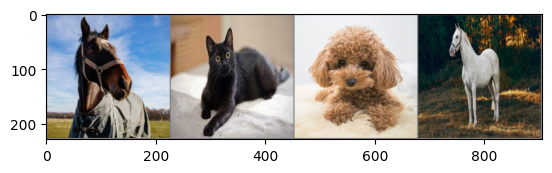

Clases: caballos gatos perros caballos


In [ ]:
# Paso 4: Definimos transformaciones y cargamos las imagenes del drive
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta a la carpeta que contiene /perros, /gatos y /caballos
data_dir = '/content/drive/MyDrive/ModeloEntrenamiento/mi_dataset'

# Cargamos las imagenes
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
classes = dataset.classes

# Creamos los conjuntos de entrenamiento y prueba (80% - 20%)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Mostrar algunas imágenes del dataset
images, labels = next(iter(trainloader))

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images[:4]))
print('Clases:', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [ ]:
# Paso 5: Cargar modelo preentrenado (ResNet18) y adaptar a 3 clases
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Paso 6: Entrenamiento del modelo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Época {epoch + 1}, mini-batch {i + 1}] pérdida: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Entrenamiento finalizado')

Entrenamiento finalizado


Precisión en test: 83.33%


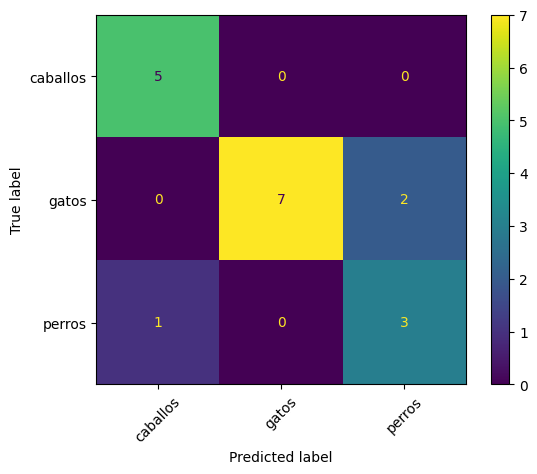

In [ ]:
# Paso 7: Evaluación y matriz de confusión
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(f'Precisión en test: {100 * correct / total:.2f}%')

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()

## Conclusiones

Durante el entrenamiento de este modelo, se ha podido comprobar que, al contar con un conjunto de datos reducido (30 imágenes por clase), la precisión de las predicciones era relativamente baja e inestable entre ejecuciones. Esto se debe a la poca variedad visual presente en el dataset, lo que limita la capacidad del modelo para generalizar correctamente.

Para mitigar este problema, se optó por aumentar el número de épocas de entrenamiento, lo que permitió al modelo ajustar mejor sus parámetros y extraer patrones más representativos de las imágenes. Este ajuste produjo una mejora progresiva en la precisión, alcanzando un 83.3% en el conjunto de prueba, aunque aumentó el tiempo de ejecución y el costo computacional.

Otro factor clave es la selección adecuada de imágenes: si las fotos no representan distintas poses, fondos y condiciones de iluminación, el modelo aprenderá a reconocer características poco generalizables, afectando negativamente su rendimiento en nuevas imágenes.

La matriz de confusión obtenida revela que:

- La clase caballos fue clasificada perfectamente en todos los casos.
- En la clase gatos, el modelo cometió dos errores al confundir gatos con perros, posiblemente por similitudes visuales.
- En la clase perros, un ejemplo fue erróneamente clasificado como caballo.

Estos errores sugieren que el modelo tiende a confundir clases visualmente similares, lo cual podría reducirse aplicando técnicas de aumento de datos o entrenando más capas del modelo. Aumentar el número de imágenes y su diversidad también ayudaría a mejorar la robustez y generalización del sistema.